In [1]:
import numpy as np
import os
import pandas as pd
import math

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u

from eventio.simtel.simtelfile import SimTelFile
import matplotlib.pyplot as plt

In [2]:
output_dir = "play_MC"

try:
    os.makedirs(output_dir, exist_ok=True)
    print("Directory ", output_dir, " Created ")
except FileExistsError:
    print("Directory ", output_dir, " already exists")

Directory  play_MC  Created 


In [225]:
window = 50.e-9
increment = 1.e-9
n_windows = 100000

nsb = 5e6
time = np.arange(0, window, 1.e-9)

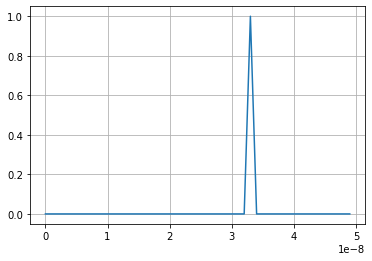

In [226]:
nsb_uni = []
ampli_uni = []
ampli_uni_max = []
n_pulses_uniform = []
time_uni = []
time_dist_uni = []

for i_waveform in range(n_windows):

    n_nsb = window*nsb
    n_nsb = np.random.poisson(n_nsb, 1)
    
    n_nsb_time = np.random.uniform(0.0, window, int(n_nsb))
    
    n_pulses_uniform.append(len(n_nsb_time))
    #if len(n_nsb_time)>0:
    time_uni.append( np.sort(list(n_nsb_time)) )
    
    amplitude_uniform = np.zeros(len(time))
    
    for i_pulse in range(len(n_nsb_time)):
        i_point = int(n_nsb_time[i_pulse]/increment)
        amplitude_uniform[i_point] = amplitude_uniform[i_point] + 1.
        
        nsb_uni.append(n_nsb_time[i_pulse])
        
    ampli_uni.append(amplitude_uniform)
    
    ampli_uni_max.append(np.max(amplitude_uniform))
    
    time_dist_tmp = []
    for i_pulse in range( len(time_uni[i_waveform])-1):
        time_dist_tmp.append(time_uni[i_waveform][i_pulse+1] - time_uni[i_waveform][i_pulse])

    time_dist_uni.append(time_dist_tmp)
        
plt.plot(time, amplitude_uniform[:len(time)])
plt.grid(True)

In [227]:
nsb_poisson = []
ampli_poisson = []
ampli_poisson_max = []
n_pulses_poiss = []
time_poiss = []
time_dist_poiss = []

for i_waveform in range(n_windows):
    
    amplitude_poiss = np.zeros(len(time))    
    amplitude_poiss = np.random.poisson(nsb*increment, len(time))
    n_pulses_poiss.append(np.sum(amplitude_poiss))
    
    ampli_poisson.append(amplitude_poiss)
    
    ampli_poisson_max.append(np.max(amplitude_poiss))
    
    time_poiss_tmp = []
    time_dist_tmp = []
    i = 0
    if(np.sum(amplitude_poiss)>0.):
        for i_time in range(len(time)):
            if(amplitude_poiss[i_time]>0.):
                for i_n in range(amplitude_poiss[i_time]):
                    time_poiss_tmp.append(time[i_time])
                    i = i + 1
                    if(i>1):
                        if(i_n == 0):
                            #print(time[i_time] - time[i_time-1])
                            time_dist_tmp.append(time_poiss_tmp[i-1] - time_poiss_tmp[i-2])
                        else:
                            time_dist_tmp.append(0.)
                
    time_poiss.append(time_poiss_tmp)
    time_dist_poiss.append(time_dist_tmp)
        


In [55]:
poisson_sim_window = np.random.poisson(nsb*window, n_windows)

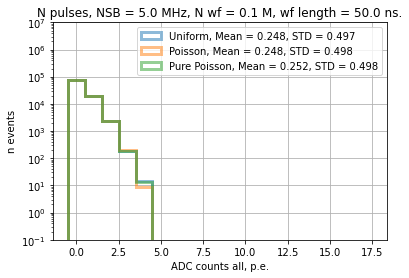

In [56]:
plt.hist(n_pulses_uniform, range =[-0.5, 17.5], linewidth=3, bins=18, alpha = 0.5, histtype=u'step', label='Uniform, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(n_pulses_uniform), np.std(n_pulses_uniform)) )
plt.hist(n_pulses_poiss, range =[-0.5, 17.5], linewidth=3, bins=18, alpha = 0.5, histtype=u'step', label='Poisson, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(n_pulses_poiss), np.std(n_pulses_poiss)) )
plt.hist(poisson_sim_window, range =[-0.5, 17.5], linewidth=3, bins=18, alpha = 0.5, histtype=u'step', label='Pure Poisson, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(poisson_sim_window), np.std(poisson_sim_window)) )
plt.title('N pulses, NSB = {:} MHz, N wf = {:} M, wf length = {:} ns.'.format(nsb/1.e6, n_windows/1.e6, window*1.e9))
plt.grid(True)
plt.yscale('log')
plt.ylim(0.1, 1.e7)
plt.ylabel('n events')
plt.xlabel('ADC counts all, p.e.')
plt.legend(frameon=True)
plt.savefig(os.path.join(output_dir, 'Npulses_l_{:.2f}_ns_nsb_{:.2f}_dist.png'.format(window/1.e-9, nsb/1.e6)), dpi=800)
plt.show()

In [175]:
plt.plot(time, amplitude_uniform[:len(time)], label='Uniform')
plt.title('Waveform, NSB = {:} MHz, waveform length = {:} ns'.format(nsb/1.e6, window*1.e9))
plt.grid(True)
plt.ylabel('n p.e.')
plt.xlabel('time, s')
plt.legend(frameon=True)
plt.show()

plt.plot(time, amplitude_poiss[:len(time)], label='Poisson', color = 'orange')
plt.title('Waveform, NSB = {:} MHz, waveform length = {:} ns'.format(nsb/1.e6, window*1.e9))
plt.grid(True)
plt.ylabel('n p.e.')
plt.legend(frameon=True)
plt.xlabel('time, s')
plt.show()

In [176]:
plt.hist(time_uni[0], range =[0, window], linewidth=3, bins=len(time), alpha = 0.5, histtype=u'step', label='Uniform' )
plt.hist(time_poiss[0], range =[0, window], linewidth=3, bins=len(time), alpha = 0.5, histtype=u'step', label='Poisson')
plt.title('NSB = {:} MHz, N waveforms = {:} M, waveform length = {:} ns.'.format(nsb/1.e6, n_windows/1.e6, window*1.e9))
plt.grid(True)
#plt.yscale('log')
#plt.ylim(0.1, 1.e3)
plt.ylabel('n, p.e]')
plt.xlabel('p.e. arrival time, s')
plt.legend(frameon=True)
plt.show()

In [228]:
time_uni_array = np.concatenate( time_uni, axis=0 )
time_dist_uni_array = np.concatenate( time_dist_uni, axis=0 )
time_poisson_array = np.concatenate( time_poiss, axis=0 )
time_dist_poisson_array = np.concatenate( time_dist_poiss, axis=0 )

In [229]:
plt.hist(time_uni_array, range =[0, window], linewidth=3, bins=len(time), alpha = 0.5, histtype=u'step', label='Uniform' )
plt.hist(time_poisson_array, range =[0, window], linewidth=3, bins=len(time), alpha = 0.5, histtype=u'step', label='Poisson')
plt.title('NSB = {:} MHz, N waveforms = {:} M, waveform length = {:} ns.'.format(nsb/1.e6, n_windows/1.e6, window*1.e9))
plt.grid(True)
#plt.yscale('log')
#plt.ylim(0.1, 1.e3)
plt.ylabel('n, p.e]')
plt.xlabel('p.e. arrival time, s')
plt.legend(frameon=True)
plt.savefig(os.path.join(output_dir, 'pulse_time_l_{:.2f}_ns_nsb_{:.2f}_dist.png'.format(window/1.e-9, nsb/1.e6)), dpi=800)
plt.show()

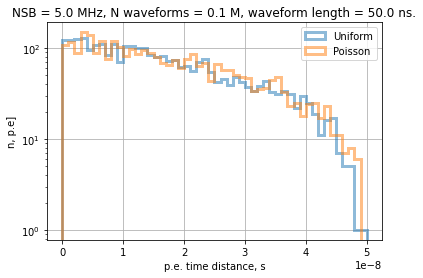

In [230]:
plt.hist(time_dist_uni_array, range =[0, window], linewidth=3, bins=len(time), alpha = 0.5, histtype=u'step', label='Uniform' )
plt.hist(time_dist_poisson_array, range =[0, window], linewidth=3, bins=len(time), alpha = 0.5, histtype=u'step', label='Poisson')
plt.title('NSB = {:} MHz, N waveforms = {:} M, waveform length = {:} ns.'.format(nsb/1.e6, n_windows/1.e6, window*1.e9))
plt.grid(True)
plt.yscale('log')
#plt.ylim(0.1, 1.e3)
plt.ylabel('n, p.e]')
plt.xlabel('p.e. time distance, s')
plt.legend(frameon=True)
plt.savefig(os.path.join(output_dir, 'Time_dist_l_{:.2f}_ns_nsb_{:.2f}_dist.png'.format(window/1.e-9, nsb/1.e6)), dpi=800)
plt.show()

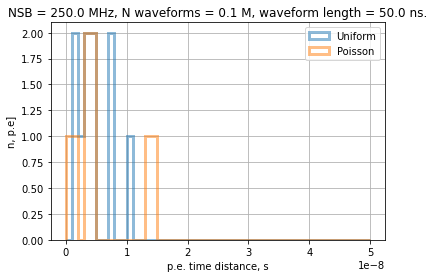

In [217]:
plt.hist(time_dist_uni[0], range =[0, window], linewidth=3, bins=len(time), alpha = 0.5, histtype=u'step', label='Uniform' )
plt.hist(time_dist_poiss[0], range =[0, window], linewidth=3, bins=len(time), alpha = 0.5, histtype=u'step', label='Poisson')
plt.title('NSB = {:} MHz, N waveforms = {:} M, waveform length = {:} ns.'.format(nsb/1.e6, n_windows/1.e6, window*1.e9))
plt.grid(True)
#plt.yscale('log')
#plt.ylim(0.1, 1.e3)
plt.ylabel('n, p.e]')
plt.xlabel('p.e. time distance, s')
plt.legend(frameon=True)
plt.show()

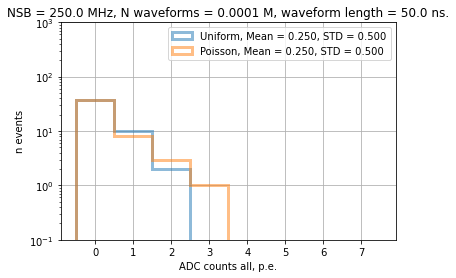

In [142]:
plt.hist(amplitude_uniform[:len(time)], range =[-0.5, 7.5], linewidth=3, bins=8, alpha = 0.5, histtype=u'step', label='Uniform, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(ampli_uni_array), np.std(ampli_uni_array)) )
plt.hist(amplitude_poiss[:len(time)], range =[-0.5, 7.5],linewidth=3, bins=8, alpha = 0.5, histtype=u'step', label='Poisson, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(ampli_poisson_array), np.std(ampli_poisson_array)) )
plt.title('NSB = {:} MHz, N waveforms = {:} M, waveform length = {:} ns.'.format(nsb/1.e6, n_windows/1.e6, window*1.e9))
plt.grid(True)
plt.yscale('log')
plt.ylim(0.1, 1.e3)
plt.ylabel('n events')
plt.xlabel('ADC counts all, p.e.')
plt.legend(frameon=True)
plt.show()

In [57]:
poisson_sim = np.random.poisson(nsb*increment, n_windows*len(time))

Uni. Mean :  0.22026  std =  0.4159152947416096
Poisson. Mean :  0.22016  std =  0.4160163150646859
100000


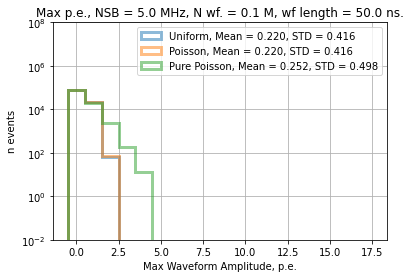

In [58]:
n_events_ampli_uni, bins_ampli_uni, patches_ampli_uni = plt.hist(ampli_uni_max, range =[-0.5, 17.5], linewidth=3, bins=18, alpha = 0.5, histtype=u'step', label='Uniform, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(ampli_uni_max), np.std(ampli_uni_max)) )
n_events_ampli_ps, bins_ampli_ps, patches_ampli_ps = plt.hist(ampli_poisson_max, range =[-0.5, 17.5], linewidth=3, bins=18, alpha = 0.5, histtype=u'step', label='Poisson, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(ampli_poisson_max), np.std(ampli_poisson_max)) )
plt.hist(poisson_sim_window, range =[-0.5, 17.5], linewidth=3, bins=18, alpha = 0.5, histtype=u'step', label='Pure Poisson, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(poisson_sim_window), np.std(poisson_sim_window)) )
plt.grid(True)
plt.yscale('log')
plt.title('Max p.e., NSB = {:} MHz, N wf. = {:} M, wf length = {:} ns.'.format(nsb/1.e6, n_windows/1.e6, window*1.e9))
plt.ylim(0.01, 1.e8)
plt.ylabel('n events')
plt.xlabel('Max Waveform Amplitude, p.e.')
plt.legend(frameon=True)

print('Uni. Mean : ', np.mean(ampli_uni_max), " std = ",  np.std(ampli_uni_max) )
print('Poisson. Mean : ', np.mean(ampli_poisson_max), " std = ",  np.std(ampli_poisson_max) )
plt.savefig(os.path.join(output_dir, 'Max_ampli_l_{:.2f}_ns_nsb_{:.2f}_dist.png'.format(window/1.e-9, nsb/1.e6)), dpi=800)
print(len(ampli_uni_max))
plt.show()

In [75]:
ampli_uni_array = np.array(ampli_uni)
ampli_uni_array = ampli_uni_array.flatten("C")
ampli_uni_array

array([0., 0., 0., ..., 0., 1., 0.])

In [76]:
ampli_poisson_array = np.array(ampli_poisson)
ampli_poisson_array = ampli_poisson_array.flatten("C")
ampli_poisson_array
#ampli_array.shape

array([0, 0, 0, ..., 1, 0, 0])

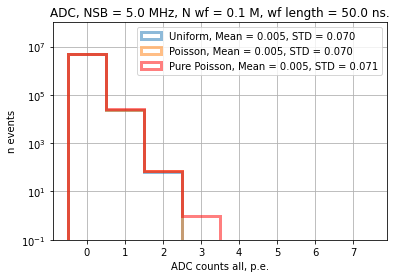

In [61]:
plt.hist(ampli_uni_array, range =[-0.5, 7.5], linewidth=3, bins=8, alpha = 0.5, histtype=u'step', label='Uniform, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(ampli_uni_array), np.std(ampli_uni_array)) )
plt.hist(ampli_poisson_array, range =[-0.5, 7.5],linewidth=3, bins=8, alpha = 0.5, histtype=u'step', label='Poisson, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(ampli_poisson_array), np.std(ampli_poisson_array)) )
plt.hist(poisson_sim, range =[-0.5, 7.5], bins=8, linewidth=3, alpha = 0.5, histtype=u'step', edgecolor='red', label='Pure Poisson, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(poisson_sim), np.std(poisson_sim)) )
plt.title('ADC, NSB = {:} MHz, N wf = {:} M, wf length = {:} ns.'.format(nsb/1.e6, n_windows/1.e6, window*1.e9))
plt.grid(True)
plt.yscale('log')
plt.ylim(0.1, 1.e8)
plt.ylabel('n events')
plt.xlabel('ADC counts all, p.e.')
plt.legend(frameon=True)
plt.savefig(os.path.join(output_dir, 'ADC_counts_l_{:.2f}_ns_nsb_{:.2f}_dist.png'.format(window/1.e-9, nsb/1.e6)), dpi=800)
plt.show()

In [ ]:
plt.hist(ampli_array, range =[-0.5, 5.5], bins=6, label='Poisson' )
plt.grid(True)
plt.yscale('log')
plt.ylim(0.01, 1.e8)
plt.ylabel('n events')
plt.xlabel('Amplitude')
plt.show()

In [81]:
for i in range(1000):
    plt.plot(time, ampli_poisson[i])
    
plt.grid(True)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.show()

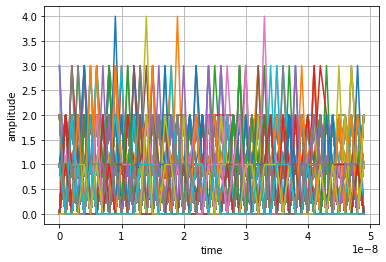

In [82]:
for i in range(1000):
    plt.plot(time, ampli_uni[i])
    
plt.grid(True)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.show()

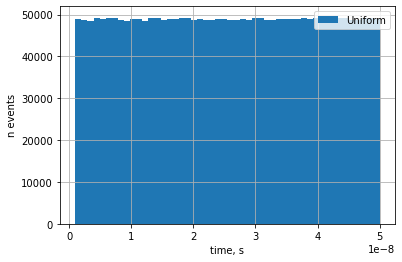

In [ ]:
n_events_uni, bins_uni, patches_uni = plt.hist(nsb_uni, range =[1.e-9, window], bins=50, label='Uniform' )
plt.grid(True)
plt.grid(True)
plt.legend(frameon=True)
plt.ylabel('n events')
plt.xlabel('time, s')
plt.savefig(os.path.join(output_dir, 'Time_l_{:.2f}_ns_dist.png'.format(window/1.e-9)), dpi=800)
plt.show()

n_events_ampli_uni, bins_ampli_uni, patches_ampli_uni = plt.hist(amplitude_uniform, range =[-0.5, 5.5], bins=6, label='Uniform' )
plt.hist(ampli_poisson, range =[-0.5, 5.5], bins=6, label='Poisson' )


plt.grid(True)
plt.yscale('log')
plt.ylim(0.01, 1.e4)
plt.ylabel('n events')
plt.xlabel('Amplitude')
plt.show()

250004
250004
5000080.0
5000080.0


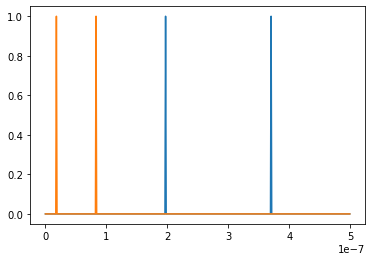

In [151]:
window = 500.e-9
increment = 1.e-9
n_windows = 100000

nsb = 5e6

time = np.arange(0, window, 1.e-9)

nsb_expo = []
nsb_uni = []

ampli_expo = []
ampli_uni = []

amplitude_uniform = np.zeros(n_windows*len(time))
amplitude_expo = np.zeros(n_windows*len(time))

for i_waveform in range(n_windows):

    n_nsb = window*nsb
    n_nsb = np.random.poisson(n_nsb, 1)
    #print(n_nsb)
    
    
    n_nsb_time = np.random.uniform(0.0, window, int(n_nsb))
    n_nsb_time_expo = np.random.exponential(1/(nsb), int(n_nsb))
    #print(len(n_nsb_time), " ", len(n_nsb_time_expo))

    
    for i_pulse in range(len(n_nsb_time)):
        i_point = i_waveform*(len(time)) + int(n_nsb_time[i_pulse]/increment)
        amplitude_uniform[i_point] = amplitude_uniform[i_point] + 1.
        nsb_uni.append(n_nsb_time[i_pulse])
        
    #ampli_uni.append(np.max(amplitude_uniform))

    for i_pulse_exp in range(len(n_nsb_time_expo)):
        
        n_nsb_time_expo[i_pulse_exp] = n_nsb_time_expo[i_pulse_exp]%window
        i_point_exp = i_waveform*(len(time)) +  int(n_nsb_time_expo[i_pulse_exp]/increment)
        
        
        #if( i_point_exp>=len(amplitude_expo) ):
            #print(i_point_exp, " ", len(amplitude_expo), " ", int(i_point_exp%len(amplitude_expo)))
            #i_point_exp = int(i_point_exp%len(amplitude_expo))
            #n_nsb_time_expo[i_pulse_exp] = time[i_pulse_exp]
        
        #if(i_point_exp<len(amplitude_expo)):
            #print(i_point_exp, time[i_point_exp], n_nsb_time_expo[i_pulse_exp])
        amplitude_expo[i_point_exp] = amplitude_expo[i_point_exp] + 1.    
        nsb_expo.append(n_nsb_time_expo[i_pulse_exp]%window )
        
        
    ampli_uni.append(np.max(amplitude_uniform[int(i_waveform*(len(time))):int((i_waveform+1)*(len(time)))]))
    ampli_expo.append(np.max(amplitude_expo[int(i_waveform*(len(time))):int((i_waveform+1)*(len(time)))]))
        
plt.plot(time, amplitude_uniform[:len(time)])
plt.plot(time, amplitude_expo[:len(time)])
    
    
#plt.grid(True)
#plt.show()
    
print(len(nsb_uni))
print(len(nsb_expo))

print(np.sum(amplitude_uniform)/(n_windows*window))
print(np.sum(amplitude_expo)/(n_windows*window))
#print(np.mean(ampli_uni))
#print(np.mean(ampli_expo))


25047
25047
5009400.0
5009400.0


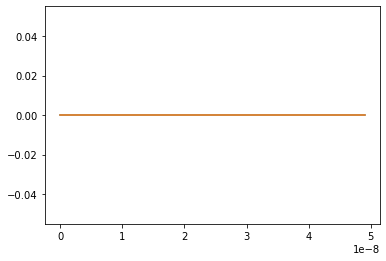

In [4]:
window = 50.e-9
increment = 1.e-9
n_windows = 100000

nsb = 5e6

time = np.arange(0, window, 1.e-9)

nsb_expo = []
nsb_uni = []
nsb_expo_poisson = []

ampli_expo = []
ampli_expo_poisson = []
ampli_uni = []

amplitude_uniform = np.zeros(n_windows*len(time))
amplitude_expo = np.zeros(n_windows*len(time))
amplitude_expo_poisson = np.zeros(n_windows*len(time))

for i_waveform in range(n_windows):

    n_nsb = window*nsb
    n_nsb = np.random.poisson(n_nsb, 1)
    #print(n_nsb, " ", window*nsb)
    
    #amplitude_expo_poisson = np.zeros(len(time))
    
    n_nsb_time = np.random.uniform(0.0, window, int(n_nsb))
    n_nsb_time_expo = np.random.exponential(1/(nsb), int(n_nsb))
    #print(len(n_nsb_time), " ", len(n_nsb_time_expo))

    
    for i_pulse in range(len(n_nsb_time)):
        i_point = i_waveform*(len(time)) + int(n_nsb_time[i_pulse]/increment)
        amplitude_uniform[i_point] = amplitude_uniform[i_point] + 1.
        nsb_uni.append(n_nsb_time[i_pulse])
        
    #ampli_uni.append(np.max(amplitude_uniform))

    for i_pulse_exp in range(len(n_nsb_time_expo)):
        
        n_nsb_time_expo[i_pulse_exp] = n_nsb_time_expo[i_pulse_exp]%window
        i_point_exp = i_waveform*(len(time)) +  int(n_nsb_time_expo[i_pulse_exp]/increment)
        
        
        #if( i_point_exp>=len(amplitude_expo) ):
            #print(i_point_exp, " ", len(amplitude_expo), " ", int(i_point_exp%len(amplitude_expo)))
            #i_point_exp = int(i_point_exp%len(amplitude_expo))
            #n_nsb_time_expo[i_pulse_exp] = time[i_pulse_exp]
        
        #if(i_point_exp<len(amplitude_expo)):
            #print(i_point_exp, time[i_point_exp], n_nsb_time_expo[i_pulse_exp])
        amplitude_expo[i_point_exp] = amplitude_expo[i_point_exp] + 1  
        #amplitude_expo_poisson[i_point_exp] = amplitude_expo_poisson[i_point_exp] + np.random.poisson(nsb*increment, 1)  
        
        nsb_expo.append(n_nsb_time_expo[i_pulse_exp]%window )
        
    for i_point_all in range(len(time)):
        amplitude_expo_poisson[int(i_waveform*(len(time))) + i_point_all] = np.random.poisson(nsb*increment, 1)  
        
        
    ampli_uni.append(np.max(amplitude_uniform[int(i_waveform*(len(time))):int((i_waveform+1)*(len(time)))]))
    ampli_expo.append(np.max(amplitude_expo[int(i_waveform*(len(time))):int((i_waveform+1)*(len(time)))]))
    ampli_expo_poisson.append(np.max(amplitude_expo_poisson[int(i_waveform*(len(time))):int((i_waveform+1)*(len(time)))]))
        
plt.plot(time, amplitude_uniform[:len(time)])
plt.plot(time, amplitude_expo[:len(time)])
    
    
#plt.grid(True)
#plt.show()
    
print(len(nsb_uni))
print(len(nsb_expo))

print(np.sum(amplitude_uniform)/(n_windows*window))
print(np.sum(amplitude_expo)/(n_windows*window))
#print(np.mean(ampli_uni))
#print(np.mean(ampli_expo))


Integral :  24547.0
mean :  490.94
std  :  24.876020582078638


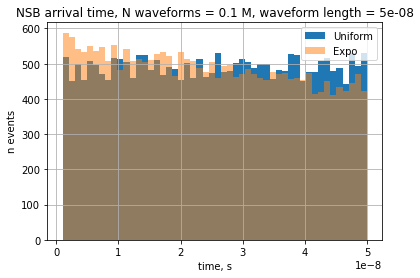

Integral :  24473.0
mean :  489.46
std  :  42.254566617112516


In [5]:
n_events_uni, bins_uni, patches_uni = plt.hist(nsb_uni, range =[1.e-9, window], bins=50, label='Uniform' )
plt.grid(True)
#plt.show()

print('Integral : ', np.sum(n_events_uni))
print('mean : ', np.mean(n_events_uni))
print('std  : ', np.std(n_events_uni))

n_events_expo, bins_expo, patches_expo = plt.hist(nsb_expo, range =[1.e-9, window], bins=50, alpha = 0.5, label='Expo')

plt.title('NSB arrival time, N waveforms = {:} M, waveform length = {:}'.format(n_windows/1.e6, window))

plt.grid(True)
plt.legend(frameon=True)
plt.ylabel('n events')
plt.xlabel('time, s')
plt.savefig(os.path.join(output_dir, 'Time_l_{:.2f}_ns_dist.png'.format(window/1.e-9)), dpi=800)
plt.show()

print('Integral : ', np.sum(n_events_expo))
print('mean : ', np.mean(n_events_expo))
print('std  : ', np.std(n_events_expo))

In [6]:
mean_p = -math.log(n_events_uni[1]/np.sum(n_events_uni))
print(window*nsb)
n_random=np.random.poisson(window*nsb, int(n_windows))

0.25


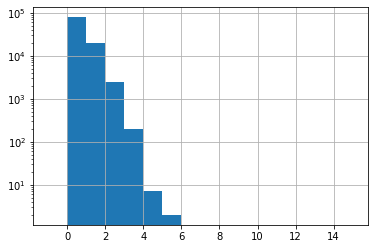

In [7]:
plt.hist(n_random, bins = 16, range=[-1, 15])
#plt.hist(10*n_random, bins=50, range = [-10, 40])
plt.grid(True)
plt.yscale('log')
plt.show()

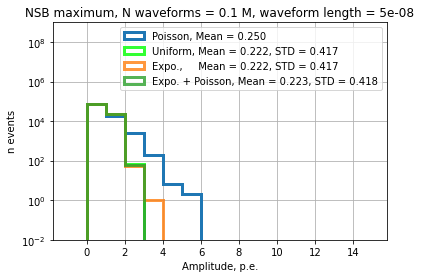

In [8]:
plt.hist(n_random, bins = 16, range=[-1, 15], histtype=u'step', linewidth=3, label='Poisson, Mean = {:.3f}'.format(window*nsb))

n_events_uni, bins_uni, patches_uni = plt.hist(ampli_uni, bins=16, range=[-1, 15], histtype=u'step', linewidth=3, color = "lime", alpha=0.8, label='Uniform, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(ampli_uni), np.std(ampli_uni)))
plt.title('NSB maximum, N waveforms = {:} M, waveform length = {:}'.format(n_windows/1.e6, window))

plt.grid(True)
plt.yscale('log')
#plt.ylim(0.01, 1.e6)
plt.legend(frameon=True)
#plt.show()


n_events_exp, bins_exp, patches_exp = plt.hist(ampli_expo, bins=16, histtype=u'step', linewidth=3, range=[-1, 15], alpha=0.8, label='Expo.,     Mean = {:.3f}, STD = {:.3f}'.format(np.mean(ampli_expo), np.std(ampli_expo)))
n_events_exp_poisson, bins_exp_poisson, patches_exp_poisson = plt.hist(ampli_expo_poisson, bins=16, histtype=u'step', linewidth=3, range=[-1, 15], alpha=0.8, label='Expo. + Poisson, Mean = {:.3f}, STD = {:.3f}'.format(np.mean(ampli_expo_poisson), np.std(ampli_expo_poisson)))
plt.grid(True)
plt.yscale('log')
plt.ylim(0.01, 1.e9)
plt.legend(frameon=True)
plt.ylabel('n events')
plt.xlabel('Amplitude, p.e.')
plt.savefig(os.path.join(output_dir, 'Ampli_l_{:.2f}_ns_dist.png'.format(window/1.e-9)), dpi=800)
plt.show()

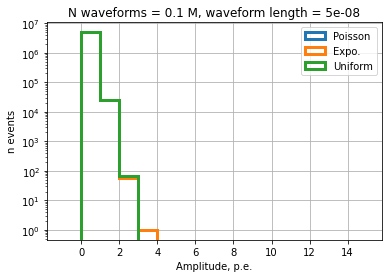

In [11]:


plt.hist(amplitude_expo_poisson, bins = 16, range=[-1, 15], histtype=u'step', linewidth=3,  label='Poisson')
plt.hist(amplitude_expo, bins = 16, range=[-1, 15], histtype=u'step', linewidth=3,  label='Expo.')
plt.hist(amplitude_uniform, bins = 16, range=[-1, 15], histtype=u'step', linewidth=3, label='Uniform')
plt.title('N waveforms = {:} M, waveform length = {:}'.format(n_windows/1.e6, window))

plt.grid(True)
plt.yscale('log')
#plt.ylim(0.01, 1.e6)
plt.ylabel('n events')
plt.xlabel('Amplitude, p.e.')
plt.legend(frameon=True)
plt.savefig(os.path.join(output_dir, 'Ampli_test_2l_{:.2f}_ns_dist.png'.format(window/1.e-9)), dpi=800)
plt.show()

In [400]:
np.mean(amplitude_expo_poisson)

0.0626662

In [278]:
print(np.sum(n_events_exp_poisson))
print(np.sum(n_events_exp))
print(np.sum(n_events_uni))

999999.0
1000000.0
1000000.0


In [120]:
print(-math.log(n_events_uni[1]/np.sum(n_events_uni)))
print(-math.log(n_events_exp[1]/np.sum(n_events_exp)))

0.2493232690975948
0.2493232690975948


In [113]:
n_events_uni[1]

82106.0

In [39]:
print(-math.log(n_events_uni[2]/np.sum(n_events_uni)))
print(-math.log(n_events_exp[2]/np.sum(n_events_exp)))

1.489435120039404
1.4920994200168671


In [36]:
-math.log(n_events_uni[2]/np.sum(n_events_uni))

1.489435120039404

In [37]:
-math.log(n_events_uni[3]/np.sum(n_events_uni))

8.111728083308073

In [88]:
np.std(ampli_expo)

0.4163520866958636

In [89]:
np.std(ampli_uni)

0.37818718873594864

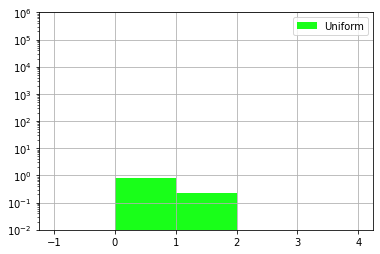

1.0
0.221838
0.41700347930922593


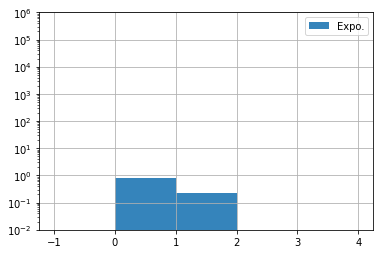

1.0
0.221832
0.4169850881938105


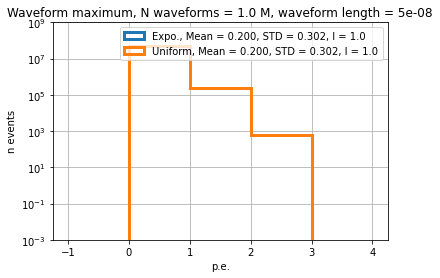

In [63]:
n_events_uni, bins_uni, patches_uni = plt.hist(ampli_uni, bins=5, range=[-1, 4], density=True, color = "lime", alpha=0.9, label='Uniform')
plt.grid(True)
plt.yscale('log')
plt.ylim(0.01, 1.e6)
plt.legend(frameon=True)
plt.show()

print(np.sum(n_events_uni))
print(np.mean(ampli_uni))
print(np.std(ampli_uni))


n_events_exp, bins_exp, patches_exp = plt.hist(ampli_expo, bins=5, range=[-1, 4], density=True, alpha=0.9, label='Expo.')
plt.grid(True)
plt.yscale('log')
plt.ylim(0.01, 1.e6)
plt.legend(frameon=True)
plt.show()

print(np.sum(n_events_exp))
print(np.mean(ampli_expo))
print(np.std(ampli_expo))

plt.title('Waveform maximum, N waveforms = {:} M, waveform length = {:}'.format(n_windows/1.e6, window))
plt.hist(amplitude_expo, bins=5, range=[-1, 4], histtype=u'step', linewidth=3, label='Expo., Mean = {:.3f}, STD = {:.3f}, I = {:2.1f}'.format(np.mean(n_events_exp), np.std(n_events_exp), np.sum(n_events_exp)))
plt.hist(amplitude_uniform, bins=5, range=[-1, 4], histtype=u'step', linewidth=3, label='Uniform, Mean = {:.3f}, STD = {:.3f}, I = {:2.1f}'.format(np.mean(n_events_uni), np.std(n_events_uni), np.sum(n_events_uni)))
plt.grid(True)
plt.yscale('log')
plt.ylim(0.001, 10.e8)
plt.legend(frameon=True)
plt.ylabel('n events')
plt.xlabel('p.e.')
plt.savefig('Amplitude_l_{:.2f}_ns_dist.png'.format(window/1.e-9), dpi=600)
plt.show()

In [19]:
def get_mean(x, y):
    
    x_arr = np.array(x)
    y_arr = np.array(y)
    
    return np.sum(x_arr*y_arr)

In [22]:
amplitude_expo.mean()

AttributeError: 'list' object has no attribute 'mean'

In [51]:
np.array(ampli_expo).std()

0.4168611413120682

In [50]:
np.array(ampli_uni).std()

0.41702907926906013

In [251]:
amplitude_uniform.mean()

0.01001444

In [236]:
get_mean(n_events_uni, bins_uni[:-1]+0.5)

0.54998708

In [225]:
bins_exp+0.5

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5])

In [227]:
n_events_exp

array([0.000000e+00, 2.379520e+07, 1.161246e+06, 4.225800e+04,
       1.295000e+03])

In [109]:
np.random.exponential(1/nsb, 100)

array([2.76629794e-07, 7.61094473e-07, 2.16633695e-07, 3.04971362e-07,
       4.18556865e-08, 1.86863897e-07, 9.18183455e-08, 6.74661926e-09,
       4.39256520e-09, 6.00940706e-08, 4.83056789e-08, 2.97199014e-08,
       3.68834392e-07, 3.20848953e-07, 1.39863684e-07, 3.14803494e-07,
       1.87726695e-07, 4.21171943e-08, 1.04492260e-07, 7.73239914e-08,
       1.25517787e-07, 5.84527869e-08, 1.60394629e-07, 1.98097027e-07,
       2.70060675e-08, 1.66302206e-07, 1.75598842e-08, 3.67938781e-07,
       5.84164990e-08, 3.39297981e-07, 3.04903566e-07, 1.72421557e-07,
       1.05444600e-07, 1.31445602e-08, 1.04533066e-08, 2.87170197e-07,
       6.07244788e-08, 4.68630140e-07, 4.63834597e-09, 1.82719364e-07,
       1.32664956e-07, 2.85786838e-07, 3.73110306e-07, 5.56976690e-07,
       2.83973821e-11, 4.22147368e-11, 5.35815513e-08, 1.92767933e-07,
       4.85526203e-08, 9.09898991e-08, 4.43252447e-07, 8.19963736e-08,
       3.71732822e-07, 6.89659376e-07, 1.38847653e-07, 7.14362159e-08,
      